In [44]:
import os.path
import numpy as np

#Ensures we use Tensorflow 1.x
#%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow_addons as tfa
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

import pandas as pd
from sklearn.linear_model import LinearRegression
from astropy.stats import median_absolute_deviation
import numpy as np
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from sklearn.linear_model import Ridge

2.0.0


In [45]:
print(tf.__version__)
import tensorflow_addons as tfa

2.0.0


In [46]:
# rv_net imports.
import sys
sys.path.append("rv_net/")
from ops import training
from tf_util import config_util
from tf_util import configdict
from tf_util import estimator_runner
from rv_net import data_HARPS_N
from rv_net import  data, rv_model, estimator_util, load_dataset_ridge, ridge_regress_harps

In [47]:
# @title Residual plotting code
import matplotlib.pylab as mpl
def residual_plot(rv_list, x_axis, ccfs_of_interest, num_ref_ccf, plot_title):
    # create color scheme
    min_rv = np.min(rv_list)
    max_rv = np.max(rv_list)
    cscale_residuals = (np.array(rv_list - min_rv) / (max_rv - min_rv))
    print(np.min(cscale_residuals), np.max(cscale_residuals))

    col = plt.cm.jet([0.25, 0.75])
    n = len(ccfs_of_interest)
    colors = plt.cm.bwr(cscale_residuals)

    # Create the residual plot by looping through the list of CCFs ordered by date
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    num = 0
    for i in np.arange(0, len(ccfs_of_interest)):
        if num_ref_ccf == "median":
            plt.plot(x_axis, ccfs_of_interest[i] - np.median(list(ccfs_of_interest), axis=0), color=colors[num])
        else:
            if i != num_ref_ccf:
                plt.plot(x_axis, ccfs_of_interest[i] - ccfs_of_interest[num_ref_ccf], color=colors[num])
        num += 1

    plt.title(plot_title)
    # make color bar
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=(min_rv - np.median(rv_list)), vmax=(max_rv - np.median(rv_list)))
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="vertical", pad=-0.0001)
    cb.set_label(label='Stellar Activity Signal (m/s)', size=16, rotation=270, labelpad=20)

## Reading in the data

In [48]:
eval_method ='cross_val' #"val"#'cross_val' #"val"# "val"#"cross_val" # "val" # "test"

ccf_len = 46

In [49]:
# Change this path to point towards the location of the files in your drive

!ls 'TF_records_Nov2021'

TF_ccf_cross_val0 TF_ccf_cross_val4 TF_ccf_cross_val8 TF_ccf_val
TF_ccf_cross_val1 TF_ccf_cross_val5 TF_ccf_cross_val9
TF_ccf_cross_val2 TF_ccf_cross_val6 TF_ccf_full_train
TF_ccf_cross_val3 TF_ccf_cross_val7 TF_ccf_test


In [50]:
# Read in files for cross-validation
DATA_DIR = 'TF_records_Nov2021/' #TF_record_July_10_21_no_planets_median_prov_rvs/' #HARPS-N Solar Telescope Data (using old DRS)/' #TF_record_July_10_21_no_planets_same_test_set' #TF_record_July_10_21_no_planets_v2'

if eval_method =="cross_val":
  data_files = tf.data.Dataset.list_files(DATA_DIR+'*cross_val*',shuffle=False)
  data_files = [t.numpy() for t in data_files]
  TRAIN_FILE_NAME_LIST = []
  VAL_FILE_NAME_LIST = []

  N = len(data_files)
  for i in range(N):
    val_files = [data_files[i]]
    #print(val_files)
    VAL_FILE_NAME_LIST.append(val_files)
    train_files = data_files[0:i] + data_files[i+1:]
    TRAIN_FILE_NAME_LIST.append(train_files)
    # add all the training files

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 51

elif eval_method =="val":
  TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
  VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_val")]]#test")]]

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 61
elif eval_method =="test":
  TRAIN_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_full_train")]]
  VAL_FILE_NAME_LIST = [[os.path.join(DATA_DIR, "TF_ccf_test")]]#test")]]

  NUM_TRAINING_EXAMPLES = 503
  NUM_VALIDATION_EXAMPLES = 61
else:
  print("Please select a valid evaluation method: 'cross_val' or 'val' or 'test'")

In [51]:
print(TRAIN_FILE_NAME_LIST)
VAL_FILE_NAME_LIST

[[b'TF_records_Nov2021/TF_ccf_cross_val1', b'TF_records_Nov2021/TF_ccf_cross_val2', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_records_Nov2021/TF_ccf_cross_val7', b'TF_records_Nov2021/TF_ccf_cross_val8', b'TF_records_Nov2021/TF_ccf_cross_val9'], [b'TF_records_Nov2021/TF_ccf_cross_val0', b'TF_records_Nov2021/TF_ccf_cross_val2', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_records_Nov2021/TF_ccf_cross_val7', b'TF_records_Nov2021/TF_ccf_cross_val8', b'TF_records_Nov2021/TF_ccf_cross_val9'], [b'TF_records_Nov2021/TF_ccf_cross_val0', b'TF_records_Nov2021/TF_ccf_cross_val1', b'TF_records_Nov2021/TF_ccf_cross_val3', b'TF_records_Nov2021/TF_ccf_cross_val4', b'TF_records_Nov2021/TF_ccf_cross_val5', b'TF_records_Nov2021/TF_ccf_cross_val6', b'TF_recor

[[b'TF_records_Nov2021/TF_ccf_cross_val0'],
 [b'TF_records_Nov2021/TF_ccf_cross_val1'],
 [b'TF_records_Nov2021/TF_ccf_cross_val2'],
 [b'TF_records_Nov2021/TF_ccf_cross_val3'],
 [b'TF_records_Nov2021/TF_ccf_cross_val4'],
 [b'TF_records_Nov2021/TF_ccf_cross_val5'],
 [b'TF_records_Nov2021/TF_ccf_cross_val6'],
 [b'TF_records_Nov2021/TF_ccf_cross_val7'],
 [b'TF_records_Nov2021/TF_ccf_cross_val8'],
 [b'TF_records_Nov2021/TF_ccf_cross_val9']]

In [52]:
def _example_parser(serialized_example):
    """Parses a single tf.Example into feature and label tensors."""
    feature_name = "Rescaled CCF_residuals_cutoff"#"Rescaled CCF_residuals" #CCF_residuals
    label_name = "activity signal"#"RV",
    label2_name = "BJD"
    data_fields = {
        feature_name: tf.io.FixedLenFeature([ccf_len], tf.float32), #[161], tf.float32),
        label_name: tf.io.FixedLenFeature([], tf.float32),
        label2_name: tf.io.FixedLenFeature([], tf.float32),
    }
    parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
    return parsed_fields[feature_name], parsed_fields[label_name]*1000, parsed_fields[label2_name]

#def load_dataset(file_pattern, batch_size, mode=tf.estimator.ModeKeys.EVAL):
#  filename_dataset = tf.data.Dataset.list_files(file_pattern)
#  dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
#  if mode == tf.estimator.ModeKeys.TRAIN:
#    dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
#  dataset = dataset.map(_example_parser, num_parallel_calls=4)
#  dataset = dataset.batch(batch_size)
#  return dataset

def load_dataset(filenames, batch_size, mode=tf.estimator.ModeKeys.EVAL):
    filename_dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=NUM_TRAINING_EXAMPLES)
    dataset = dataset.map(_example_parser, num_parallel_calls=4)
    dataset = dataset.batch(batch_size)
    return dataset

In [53]:
# @title Define LinearModel, FCModel, CNNModel
class LinearModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(LinearModel, self).__init__()
        self.hparams = hparams
        #self.weights = tf.Variable(tf.zeros(self.hparams.num_features))
        self.dense_layer = tf.keras.layers.Dense(
            1, kernel_initializer=tf.zeros_initializer, use_bias=False)
        
    def call(self, features, training=False):
      # return tf.tensordot(features, self.weights, axes=1)
      return tf.squeeze(self.dense_layer(features))

class FCModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(FCModel, self).__init__()
        self.hparams = hparams
        #self.hidden_layer1 = tf.keras.layers.Dense(
        #    self.hparams.num_dense_units, activation=tf.keras.activations.relu)
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

# @title Define RVLinearModel
class CNNModel(tf.keras.Model):
    """A TensorFlow linear regression model."""

    def __init__(self, hparams):
        """Basic setup.

        Args:
          hparams: A ConfigDict of hyperparameters for building the model.

        Raises:
          ValueError: If mode is invalid.
        """
        super(CNNModel, self).__init__()
        self.hparams = hparams
        self.conv_layers = [
          tf.keras.layers.Conv1D(
              filters=hparams.num_conv_filters, 
              kernel_size=hparams.conv_kernel_size,
              activation=tf.keras.activations.relu,
              padding="same")
          for i in range(hparams.num_conv_layers)
        ]
        self.dense_layers = [
          tf.keras.layers.Dense(
              hparams.num_dense_units,
              activation=tf.keras.activations.relu)
          for i in range(hparams.num_dense_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, features, training=False):
      net = tf.expand_dims(features, -1)
      for conv in self.conv_layers:
        net = conv(net)
      batch_size, length, depth = net.shape
      net = tf.reshape(net, [batch_size, length*depth])
      for dense in self.dense_layers:
        net = dense(net)
      net = self.output_layer(net)
      return tf.squeeze(net)

In [54]:
def make_predictions(model, dataset):
  all_preds = []
  all_labels = []
  all_bjds = []
  for features, labels, bjds in dataset:
    preds = model(features, training=False)
    all_preds.append(preds.numpy())
    all_labels.append(labels.numpy())
    all_bjds.append(bjds.numpy())
  return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_bjds)

def train(model, hparams, plots, model_name, num_epochs):#=100):
  train_dataset = load_dataset([TRAIN_FILE_NAME], batch_size=hparams.batch_size, mode=tf.estimator.ModeKeys.TRAIN)
  val_dataset = load_dataset([VAL_FILE_NAME], batch_size=min(1024, NUM_VALIDATION_EXAMPLES), mode=tf.estimator.ModeKeys.EVAL)
  loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
  Opt = tfa.optimizers.extend_with_decoupled_weight_decay(tf.optimizers.SGD)
  optimizer = Opt(weight_decay=hparams.weight_decay, learning_rate=hparams.learning_rate, momentum=hparams.momentum)
  metrics = [
             tf.keras.metrics.MeanSquaredError("train_loss"),
             tf.keras.metrics.RootMeanSquaredError("train_rmse")
  ]
  weight_decay_list_t.append(hparams.weight_decay)
  gaussian_noise_list_t.append(hparams.gaussian_noise_scale)

  metric_values = []
  for epoch in range(1, num_epochs+1):
    # Reset metric values for each new epoch.
    for m in metrics:
      m.reset_states()

    # Train over all batches in the training set.
    for features, labels, bjds in train_dataset:
      if hparams.gaussian_noise_scale:
        features += tf.random.normal(features.shape, stddev=hparams.gaussian_noise_scale)
        #print(hparams.gaussian_noise_scale)
      # One training step.
      with tf.GradientTape() as t:
        preds = model(features, training=True)
        loss = loss_fn(labels, preds)
      grads = t.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # Update the metrics.
      for m in metrics:
        m(labels, preds)
    
    # End of an epoch.
    epoch_metrics = {"epoch": epoch}
    # First, log the training metrics.
    for m in metrics:
      epoch_metrics[m.name] = m.result().numpy()
    # Next, evaluate over the validation set.
    labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
    epoch_metrics["val_rmse"] = np.sqrt(np.mean(np.square(preds_val - labels_val)))
    # Add a metric for the raw scatter started with
    epoch_metrics["original_rmse"] = np.std(labels_val)
    # Add a metric for raw scatter - corrected scatter
    epoch_metrics["difference_rmse"] = np.std(labels_val) - np.sqrt(np.mean(np.square(preds_val - labels_val)))
    # Log metrics to tensorboard.
    for metric, value in epoch_metrics.items():
      tf.summary.scalar(metric, value, step=epoch)
    epoch_metrics["epoch"] = epoch
    # Print metric values at selected epochs.
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
      print("{epoch}: Train loss: {train_loss:.4}, Train RMSE: {train_rmse:.4}, Val RMSE: {val_rmse:.4}".format(**epoch_metrics))
    metric_values.append(epoch_metrics)

  # Gather predictions
  labels, preds, bjd = make_predictions(model, train_dataset)
  labels_val, preds_val, bjd_val = make_predictions(model, val_dataset)
  all_bjds_val.append(bjd_val)
  bjd_run_val.append(bjd_val)
  all_pred_val.append(preds_val)
  pred_run_val.append(preds_val)
  all_labels_val.append(labels_val)
  labels_run_val.append(labels_val)

  # Scatter reduction plot
  sd_x = np.std(labels_val, ddof=1)
  rms_x = np.sqrt(np.mean(np.square(labels_val - preds_val)))
  rms_x_list.append(rms_x)
  rms_avg_list.append(rms_x)
  stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
  x_range = np.linspace(-4,5.5, 17)
  upper_bound = x_range+rms_x
  lower_bound = x_range-rms_x

  if plots=="ON":
    fig, axes = plt.subplots(1, 2, figsize=(24, 6))
    ax = axes[0]
    ax.plot([m["train_rmse"] for m in metric_values], label="Train RMSE")
    ax.plot([m["val_rmse"] for m in metric_values], label="Validation RMSE")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")

    # Gather predictions to plot against labels.
    ax = axes[1]
    ax.plot(preds, labels, ".", label="Training")
    ax.plot(preds_val, labels_val, ".", label="Validation")
    ax.set_xlabel("Actual Y")
    ax.set_ylabel("Predicted Y")
    ax.legend(loc="lower right")

    # plot the scatter reduction plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(labels_val, preds_val, ".")
    ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
    #ax.plot(x_range,z[0]*x_range+z[1], color="blue")
    rms_fill=rms_x#0.15
    ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                    alpha=0.5, label="1 standard deviation")
    ax1.set_xlim(-4, 4);
    ax1.set_ylim(-4, 4);
    ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
    ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
    ax1.set_title(model_name+" Model Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
    #hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    ax1.text(-3.8, 3.5, textstr, size=15,
            ha="left", va="top",
            bbox=dict(boxstyle="square",
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      ))
    ax1.legend(loc="lower right")
  else:
    textstr = '\n'.join((
        r'Raw scatter=%.3f m/s' % (sd_x, ),
        r'Corrected scatter=%.3f m/s' % (rms_x, ),
        r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
    print(textstr)
    
  return metric_values

# Ridge Regression

In [12]:
class DatasetBuilder(object):
    """Dataset builder class."""

    def __init__(self, file_pattern, hparams, mode, ccf_len, repeat=1):
        """Initializes the dataset builder.
        Args:
          file_pattern: File pattern matching input file shards, e.g.
            "/tmp/train-?????-of-00100".
          hparams: A ConfigDict.
          mode: A tf.estimator.ModeKeys.
          repeat: The number of times to repeat the dataset. If None, the dataset
            will repeat indefinitely.
        """
        valid_modes = [
            tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL,
            tf.estimator.ModeKeys.PREDICT
        ]
        if mode not in valid_modes:
            raise ValueError("Expected mode in {}. Got: {}".format(valid_modes, mode))

        self.file_pattern = file_pattern
        self.hparams = hparams
        self.mode = mode
        self.repeat = repeat
        self.ccf_len = ccf_len

    def __call__(self):
        is_training = self.mode == tf.estimator.ModeKeys.TRAIN

        # Dataset of file names.
        filename_dataset = tf.data.Dataset.list_files(self.file_pattern,
                                                      shuffle=is_training)

        # Dataset of serialized tf.Examples.
        dataset = filename_dataset.flat_map(tf.data.TFRecordDataset)

        # Shuffle in training mode.
        if is_training:
            dataset = dataset.shuffle(self.hparams.shuffle_values_buffer)

        # Possibly repeat.
        if self.repeat != 1:
            dataset = dataset.repeat(self.repeat)

        def _example_parser(serialized_example):
            """Parses a single tf.Example into feature and label tensors."""
            data_fields = {
                self.hparams.ccf_feature_name: tf.io.FixedLenFeature([self.ccf_len], tf.float32),
                self.hparams.label_feature_name: tf.io.FixedLenFeature([], tf.float32),
                self.hparams.label_feature_name2: tf.io.FixedLenFeature([], tf.float32),
            }
            parsed_fields = tf.io.parse_single_example(serialized_example, features=data_fields)
            ccf_data = parsed_fields[self.hparams.ccf_feature_name]
            label = parsed_fields[self.hparams.label_feature_name]
            label *= self.hparams.label_rescale_factor  # Rescale the label.
            label2 = parsed_fields[self.hparams.label_feature_name2]
            return {
                "ccf_data": ccf_data,
                "label": label,
                "bjd": label2,
            }

        # Map the parser over the dataset.
        dataset = dataset.map(_example_parser, num_parallel_calls=4)

        # Batch results by up to batch_size.
        dataset = dataset.batch(self.hparams.batch_size)

        # Prefetch a few batches.
        dataset = dataset.prefetch(10)

        return dataset

In [13]:
def load_dataset_ridge(filename, ccf_len):
  dataset_hparams = configdict.ConfigDict(dict(
    ccf_feature_name='Rescaled CCF_residuals_cutoff',#"Rescaled CCF_residuals", #CCF_residuals
    label_feature_name= "activity signal",#"RV",
    label_feature_name2= "BJD",
    batch_size=300,
    label_rescale_factor=1000,
  ))
  dataset = DatasetBuilder(filename, dataset_hparams, tf.estimator.ModeKeys.EVAL, ccf_len)()
  batches = list(dataset)
  ccf_data, labels, bjds = zip(*[(batch["ccf_data"], batch["label"], batch["bjd"]) for batch in batches])
  ccf_data = np.concatenate(ccf_data)
  labels = np.concatenate(labels)
  bjds = np.concatenate(bjds)
  assert len(ccf_data.shape) == 2
  assert len(labels.shape) == 1
  assert len(bjds.shape) == 1
  assert ccf_data.shape[0] == labels.shape[0]
  #print("Read dataset with {} examples".format(labels.shape[0]))
  return ccf_data, labels, bjds

In [14]:
def ridge_regress_harps(TRAIN_FILE_NAME_LIST, VAL_FILE_NAME_LIST, alpha, verbose, ccf_len):
  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []
  avg_list = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, ccf_len)
    val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, ccf_len)

    pred_run_val = []
    labels_run_val = []
    bjd_run_val = []
    for k in range(0,10):
      model = Ridge(alpha=alpha).fit(train_X, train_Y)
      val_pred_Y = model.predict(val_X)
      pred_run_val.append(val_pred_Y)
      labels_run_val.append(val_Y)
      bjd_run_val.append(val_bjd)
      rms_avg = np.sqrt(np.mean(np.square(val_Y -val_pred_Y)))
      rms_avg_list.append(rms_avg)
      if verbose == True:
        print(model)
        print("________________________")
        print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
        print("rms: "+str(rms_avg))
      else:
        continue
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  avg_list.append(avg)
  print("________________________")
  print("average rms = "+str(avg)+" m/s")

  #flatten the lists
  all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
  all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
  all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]
  
  return all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_list, alpha

In [15]:
# Cross validation Ridge Regression Model Run (10 times)

all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_rms_list, alpha = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                 VAL_FILE_NAME_LIST, 
                                                                                 alpha=3.6094,#340.010636,#9.469, #340.010636,	#335.734079,#9.469, 
                                                                                 verbose=False,
                                                                                 ccf_len = 46)

________________________
average rms = 1.0802236 m/s


labels: sd: 1.8284893224673766
corrected rv: sd: 1.0849636105498959
____________________________________________
labels: MAD*1.4826: 1.7439013288736342
corrected rv: MAD*1.4826: 1.0854544334962963
____________________________________________
labels: 68 percent/2: 1.7452755212783813
corrected rv: 68 percent/2: 1.0970001339912414


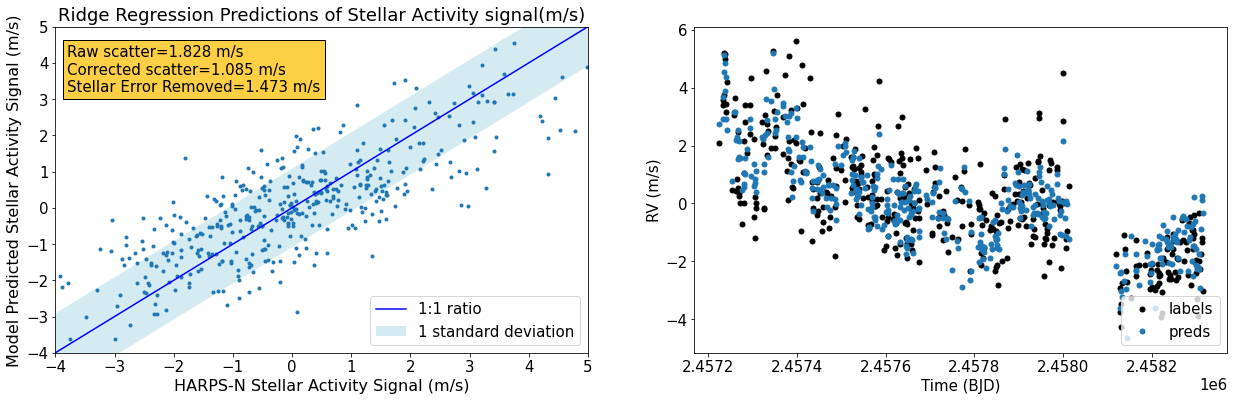

In [18]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_ridge_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("Ridge Regression Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (sd_labels, ),
    r'Corrected scatter=%.3f m/s' % (sd_corrected_rv, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 4.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

(-20.0, 20.0)

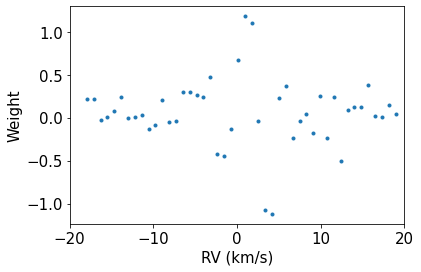

In [28]:
index=0
TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
train_X, train_Y, train_bjd  = load_dataset_ridge(TRAIN_FILE_NAME, 46)
val_X, val_Y, val_bjd = load_dataset_ridge(VAL_FILE_NAME, 46)
model = Ridge(alpha=alpha).fit(train_X, train_Y)
x_axis = np.linspace(-19.58, 19.78, 49)[2:48]
plt.plot(x_axis, model.coef_, ".")
plt.ylabel("Weight")
plt.xlabel("RV (km/s)")
plt.xlim(-20, 20)

In [29]:
# Alpha cross-val runs

# Cross validation Ridge Regression Model Run (10 times)
alpha_range = np.random.uniform(2, 5.5, 100)
#alpha_range = np.append(alpha_range, 9.469)

alpha_list = []
rms_crossval_list = []
for alpha in tqdm(alpha_range):
  all_mean_val_preds, all_mean_val_labels, all_mean_val_bjds, avg_rms_list, alpha = ridge_regress_harps(TRAIN_FILE_NAME_LIST, 
                                                                                  VAL_FILE_NAME_LIST, 
                                                                                  alpha=alpha, 
                                                                                  verbose=False,
                                                                                  ccf_len= 46)
  # compute rms across all crossval slice
  rms_crossval = np.mean(avg_rms_list)
  rms_crossval_list.append(rms_crossval)
  alpha_list.append(alpha)

  0%|          | 0/100 [00:00<?, ?it/s]

________________________
average rms = 1.0806684 m/s
________________________
average rms = 1.0806518 m/s
________________________
average rms = 1.0804646 m/s
________________________
average rms = 1.0812771 m/s
________________________
average rms = 1.0803189 m/s
________________________
average rms = 1.0817534 m/s
________________________
average rms = 1.0805019 m/s
________________________
average rms = 1.0811146 m/s
________________________
average rms = 1.0804687 m/s
________________________
average rms = 1.0813707 m/s
________________________
average rms = 1.080223 m/s
________________________
average rms = 1.0803183 m/s
________________________
average rms = 1.0805316 m/s
________________________
average rms = 1.0817243 m/s
________________________
average rms = 1.0802253 m/s
________________________
average rms = 1.0810616 m/s
________________________
average rms = 1.0802478 m/s
________________________
average rms = 1.0807314 m/s
________________________
average rms = 1.080512

In [41]:
df_rms = pd.DataFrame(list(zip(alpha_list, rms_crossval_list)), 
               columns =['alpha_list', 'avg_rms_list'])
df_rms_sorted = df_rms.sort_values(by=['avg_rms_list'])

folder = 'ridge_crossval_preds/'

if not os.path.isdir(folder):
        os.mkdir(folder)
        
df_rms_sorted.to_csv(folder+'alpha_rms_linear_12_6.csv', index = False) 

3.6602968950822814

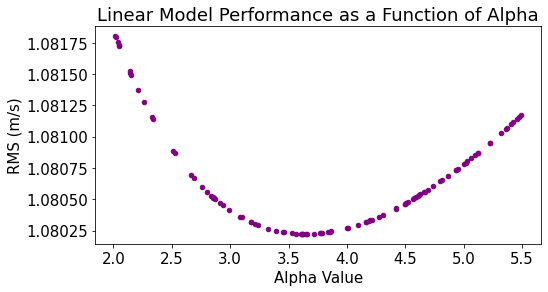

In [43]:
df_rms_sorted =pd.read_csv(folder+'alpha_rms_linear_12_6.csv')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.plot(df_rms_sorted["alpha_list"],df_rms_sorted["avg_rms_list"], ".", color='purple',
         markersize=9)
plt.title("Linear Model Performance as a Function of Alpha")
plt.xlabel("Alpha Value")
plt.ylabel("RMS (m/s)")
#plt.xlim(0, 20)
#plt.ylim(0.94, 0.95)

df_rms_sorted["alpha_list"][np.argmin(np.array(df_rms_sorted["avg_rms_list"]))]

In [48]:
# best alpha value
df_rms_sorted["alpha_list"][np.argmin(np.array(df_rms_sorted["avg_rms_list"]))]

3.6602968950822814

## FC NN Model Run

In [49]:
  # FC NN Model run

  # Cross validation Linear NN Model Run (10 times)
  rms_avg_list = []
  weight_decay_list_t = []
  gaussian_noise_list_t = []
  rms_x_list = []

  all_bjds_val = []
  all_pred_val = []
  all_labels_val = []
  all_mean_val_preds = []
  all_mean_val_bjds = []
  all_mean_val_labels = []
  all_mean_val_bjds = []

  for index in range(0, len(VAL_FILE_NAME_LIST)):
    TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
    VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
    bjd_run_val = []
    pred_run_val = []
    labels_run_val = []
    for k in range(0,10): #should be 10 for a full run
      hparams = configdict.ConfigDict(dict(
          num_features=152,#161,
          learning_rate=0.0043815, #0.0095352,#0.0016077,
          momentum=0.9,
          batch_size=300,
          num_dense_units=500,#200,
          num_dense_layers=4,
          weight_decay=0.00024022,#0.00010000, #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5, 
      ))
      model = FCModel(hparams)
      train(model, hparams, plots="OFF",model_name="FC NN", num_epochs=50)
      print(model)
      print("________________________")
      print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
    mean_val_preds = np.mean(pred_run_val, axis=0)
    mean_val_labels = np.mean(labels_run_val, axis=0)
    mean_val_bjds = np.mean(bjd_run_val, axis=0)
    all_mean_val_preds.append(mean_val_preds.tolist())
    all_mean_val_labels.append(mean_val_labels.tolist())
    all_mean_val_bjds.append(mean_val_bjds.tolist())
  avg = np.mean(rms_avg_list)
  print("________________________")
  print(avg)

  #flatten the lists
  all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
  all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
  all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

1: Train loss: 3.331, Train RMSE: 1.877, Val RMSE: 1.525
10: Train loss: 1.382, Train RMSE: 1.19, Val RMSE: 1.231
20: Train loss: 1.069, Train RMSE: 1.0, Val RMSE: 1.163
30: Train loss: 0.611, Train RMSE: 0.8142, Val RMSE: 1.203
40: Train loss: 0.4136, Train RMSE: 0.6298, Val RMSE: 1.181
50: Train loss: 0.2418, Train RMSE: 0.5083, Val RMSE: 1.207
Raw scatter=1.590 m/s
Corrected scatter=1.207 m/s
Stellar Error Removed=1.035 m/s
________________________
Cross-val number: 1, Run number: 1
1: Train loss: 3.543, Train RMSE: 1.872, Val RMSE: 1.536
10: Train loss: 1.435, Train RMSE: 1.197, Val RMSE: 1.176
20: Train loss: 0.9347, Train RMSE: 0.9583, Val RMSE: 1.167
30: Train loss: 0.7621, Train RMSE: 0.804, Val RMSE: 1.283
40: Train loss: 0.4106, Train RMSE: 0.6388, Val RMSE: 1.317
50: Train loss: 0.229, Train RMSE: 0.5008, Val RMSE: 1.279
Raw scatter=1.590 m/s
Corrected scatter=1.279 m/s
Stellar Error Removed=0.945 m/s
________________________
Cross-val number: 1, Run number: 2
1: Train loss:

30: Train loss: 0.6467, Train RMSE: 0.829, Val RMSE: 1.292
40: Train loss: 0.4176, Train RMSE: 0.6742, Val RMSE: 1.339
50: Train loss: 0.4004, Train RMSE: 0.6069, Val RMSE: 1.278
Raw scatter=1.861 m/s
Corrected scatter=1.278 m/s
Stellar Error Removed=1.352 m/s
________________________
Cross-val number: 2, Run number: 6
1: Train loss: 3.359, Train RMSE: 1.85, Val RMSE: 1.762
10: Train loss: 1.361, Train RMSE: 1.158, Val RMSE: 1.427
20: Train loss: 0.8855, Train RMSE: 0.9539, Val RMSE: 1.339
30: Train loss: 0.6142, Train RMSE: 0.814, Val RMSE: 1.274
40: Train loss: 0.4255, Train RMSE: 0.6521, Val RMSE: 1.286
50: Train loss: 0.2785, Train RMSE: 0.5241, Val RMSE: 1.3
Raw scatter=1.861 m/s
Corrected scatter=1.300 m/s
Stellar Error Removed=1.331 m/s
________________________
Cross-val number: 2, Run number: 7
1: Train loss: 3.146, Train RMSE: 1.77, Val RMSE: 1.707
10: Train loss: 1.353, Train RMSE: 1.168, Val RMSE: 1.381
20: Train loss: 0.9103, Train RMSE: 0.9572, Val RMSE: 1.359
30: Train lo

KeyboardInterrupt: 

In [50]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_FCNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("FC NN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")

ValueError: operands could not be broadcast together with shapes (3,) (42,) 

## CNN Model Run

In [ ]:
# CNN Model run

# Cross validation CNN Model Run (10 times)
rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []
all_mean_val_bjds = []

for index in range(0, len(VAL_FILE_NAME_LIST)):
  TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
  VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]
  bjd_run_val = []
  pred_run_val = []
  labels_run_val = []
  for k in range(0,10): #should be 10 for a full run
    hparams = configdict.ConfigDict(dict(
        num_features=152,
        learning_rate=0.0050618, #1e-3,
        momentum=0.9,
        batch_size=300,
        conv_kernel_size=3,
        num_conv_filters=32,
        num_conv_layers=4,
        num_dense_units=500,
        num_dense_layers=1,
        weight_decay=0.0012341, #5e-4, #7e-2,
        gaussian_noise_scale=0,#1.5,
    ))
    model = CNNModel(hparams)
    train(model, hparams, plots="OFF",model_name="CNN", num_epochs=35)#65)
    print(model)
    print("________________________")
    print("Cross-val number: "+str(index+1)+", Run number: "+str(k+1))
  mean_val_preds = np.mean(pred_run_val, axis=0)
  mean_val_labels = np.mean(labels_run_val, axis=0)
  mean_val_bjds = np.mean(bjd_run_val, axis=0)
  all_mean_val_preds.append(mean_val_preds.tolist())
  all_mean_val_labels.append(mean_val_labels.tolist())
  all_mean_val_bjds.append(mean_val_bjds.tolist())
avg = np.mean(rms_avg_list)
print("________________________")
print(avg)

#flatten the lists
all_mean_val_preds = [item for sublist in all_mean_val_preds for item in sublist]
all_mean_val_labels = [item for sublist in all_mean_val_labels for item in sublist]
all_mean_val_bjds = [item for sublist in all_mean_val_bjds for item in sublist]

In [ ]:
df = pd.DataFrame(list(zip(all_mean_val_labels,all_mean_val_preds, all_mean_val_bjds)), 
               columns =['labels', 'preds', 'BJD']) 
df_sorted = df.sort_values(by=['BJD'])
#df_sorted.to_excel('gdrive/Shared drives/Exoplanet_RV/cross_val_preds/val_preds_CNN_06_30_2021.xlsx', index = False)

# calculation of scatter removed
from astropy.stats import median_absolute_deviation

#df_sorted = df_from_excel
labels_68_percent_by_2 = (np.percentile(df_sorted["labels"], 84)-np.percentile(df_sorted["labels"], 16))/2
labels_median_absolute_deviation_norm = median_absolute_deviation(df_sorted["labels"])*1.4826
preds_68_percent_by_2 = (np.percentile(df_sorted["preds"], 84)-np.percentile(df_sorted["preds"], 16))/2

corrected_rvs = df_sorted["labels"]-df_sorted["preds"]
corrected_rvs_68_percent_by_2 = (np.percentile(corrected_rvs, 84)-np.percentile(corrected_rvs, 16))/2
corrected_rvs_median_absolute_deviation_norm = median_absolute_deviation(corrected_rvs)*1.4826

sd_labels = np.std(df_sorted["labels"], ddof=1)
sd_corrected_rv = np.std(corrected_rvs, ddof=1)
rms_x = np.sqrt(np.mean(np.square(df_sorted["labels"] - df_sorted["preds"])))


print("labels: sd: "+str(sd_labels))
print("corrected rv: sd: "+str(sd_corrected_rv))
print("____________________________________________")
print("labels: MAD*1.4826: "+str(labels_median_absolute_deviation_norm))
print("corrected rv: MAD*1.4826: "+str(corrected_rvs_median_absolute_deviation_norm))
print("____________________________________________")
print("labels: 68 percent/2: "+str(labels_68_percent_by_2))
print("corrected rv: 68 percent/2: "+str(corrected_rvs_68_percent_by_2))


# plot the average results
# Scatter reduction plot
rms_avg_list = []
sd_x = np.std(all_mean_val_labels, ddof=1)
rms_x = np.sqrt(np.mean(np.square(all_mean_val_labels - np.array(all_mean_val_preds))))
#rms_x_list.append(rms_x)
rms_avg_list.append(rms_x)
stel_removed = np.sqrt(np.abs(sd_x**2-rms_x**2))
x_range = np.linspace(-4,5.5, 17)
upper_bound = x_range+rms_x
lower_bound = x_range-rms_x

# plot the scatter reduction plot
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax1 = ax[0]
ax1.plot(df_sorted["labels"], df_sorted["preds"], ".")
ax1.plot(x_range,x_range, color="blue", label="1:1 ratio")
#ax.plot(x_range,z[0]*x_range+z[1], color="blue")
rms_fill=rms_x#0.15
ax1.fill_between(x_range, x_range+rms_fill, x_range-rms_fill, facecolor='lightblue',
                alpha=0.5, label="1 standard deviation")
ax1.set_xlim(-4, 5);
ax1.set_ylim(-4, 5);
ax1.set_xlabel("HARPS-N Stellar Activity Signal (m/s)", size =16)
ax1.set_ylabel("Model Predicted Stellar Activity Signal (m/s)", size =16)
ax1.set_title("CNN Predictions of Stellar Activity signal(m/s)") #, %d epochs, weight decay: %.2e, gauss noise: %.2e " %(num_epochs, 
#hparams.weight_decay, hparams.gaussian_noise_scale, size=16)
textstr = '\n'.join((
    r'Raw scatter=%.3f m/s' % (labels_68_percent_by_2, ),
    r'Corrected scatter=%.3f m/s' % (corrected_rvs_68_percent_by_2, ),
    r'Stellar Error Removed=%.3f m/s' % (stel_removed, )))
ax1.text(-3.8, 3.5, textstr, size=15,
        ha="left", va="top",
        bbox=dict(facecolor='#fdcf44',edgecolor='k',
                  boxstyle="square",
                  #ec=(1., 0.5, 0.5),
                  #fc=(1., 0.8, 0.8),
                  ))
ax1.legend(loc="lower right")

# plot predictions over time
ax2 = ax[1]
ax2.plot(df_sorted["BJD"], df_sorted["labels"], ".",color='k',
         markersize=10,label="labels")
ax2.plot(df_sorted["BJD"], df_sorted["preds"], ".", markersize=10,
         label="preds")
ax2.set_xlabel("Time (BJD)")
ax2.set_ylabel("RV (m/s)")
ax2.legend(loc="lower right")


# FC NN Optimize Hyperparameters (08.31.21)

In [19]:
from tensorboard.plugins.hparams import api as hp
import shutil
import time

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [63]:
# Define the ranges of values that each hyperparameter can take

x = np.random.uniform(1,5, 1000)
learning_rate_list = [10**-x][0]

dense_units_list = [100, 200, 500, 1000]
num_dense_layers_list = [4, 8, 12, 16] #[1, 2, 4, 8, 12, 16]
weight_decay_list = np.geomspace(0.0001, 0.008, 6)

num_epochs_list = [30, 35, 40, 45, 50] #[50, 55, 65, 70, 80, 90, 100]

In [64]:
learning_rate_list

array([1.00367771e-03, 2.84337162e-02, 9.97102614e-02, 4.50422720e-04,
       9.52609063e-05, 1.37512477e-04, 2.98877217e-05, 2.84694687e-02,
       2.49346583e-04, 2.65131264e-02, 2.14312269e-05, 3.45292726e-02,
       2.42783867e-04, 6.48514370e-05, 2.17392649e-02, 2.55187896e-04,
       2.73325528e-05, 2.93763273e-05, 1.33713806e-04, 8.60632766e-02,
       1.29416082e-04, 4.65547340e-03, 3.06003121e-04, 5.55674853e-04,
       2.26351770e-05, 1.97853132e-04, 3.23743129e-03, 1.07319530e-02,
       6.16306937e-03, 5.19162773e-04, 1.06890701e-02, 4.14752399e-02,
       1.46559623e-03, 1.11055013e-05, 9.66977763e-03, 1.73914507e-04,
       6.92596827e-05, 6.05189586e-04, 1.39121586e-04, 2.98591117e-04,
       5.62565775e-04, 9.52729962e-02, 2.53757651e-04, 1.35169003e-02,
       1.76207625e-03, 3.47836664e-04, 2.67943628e-04, 5.30083648e-04,
       2.69354387e-04, 6.92489821e-03, 1.52534354e-04, 1.45832890e-02,
       5.14698211e-05, 1.58359615e-03, 4.53497921e-05, 1.94804479e-05,
      

gdrive/Shareddrives/Exoplanet_RV/logs/20211208-152715
Model 1. Learning_rate: 0.00079. Dense units: 1000. Dense layers 1. Weight decay: 0.00295
Cross-val number: 1, Model archictect. num: 1, Run number: 1
1: Train loss: 3.066, Train RMSE: 1.751, Val RMSE: 1.518
10: Train loss: 1.641, Train RMSE: 1.281, Val RMSE: 1.285
20: Train loss: 1.6, Train RMSE: 1.265, Val RMSE: 1.271
30: Train loss: 1.403, Train RMSE: 1.184, Val RMSE: 1.149
40: Train loss: 1.339, Train RMSE: 1.157, Val RMSE: 1.159
50: Train loss: 1.284, Train RMSE: 1.133, Val RMSE: 1.164
60: Train loss: 1.252, Train RMSE: 1.119, Val RMSE: 1.149
70: Train loss: 1.23, Train RMSE: 1.109, Val RMSE: 1.145
80: Train loss: 1.211, Train RMSE: 1.101, Val RMSE: 1.149
90: Train loss: 1.196, Train RMSE: 1.094, Val RMSE: 1.148
100: Train loss: 1.184, Train RMSE: 1.088, Val RMSE: 1.146
________________________

Model 1. Learning_rate: 0.00079. Dense units: 1000. Dense layers 1. Weight decay: 0.00295
Cross-val number: 2, Model archictect. num: 

KeyboardInterrupt: 

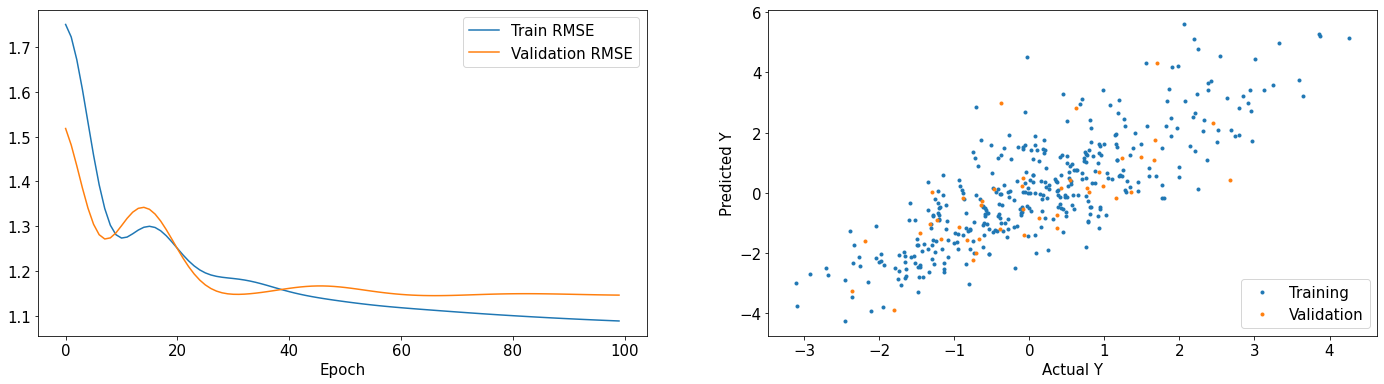

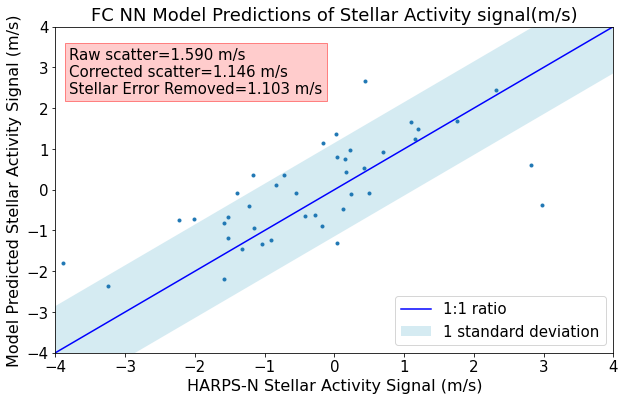

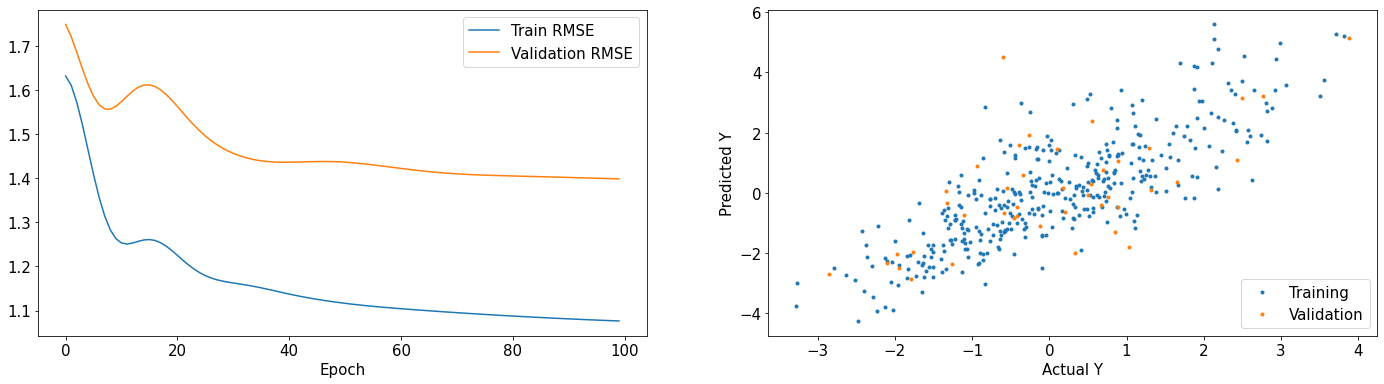

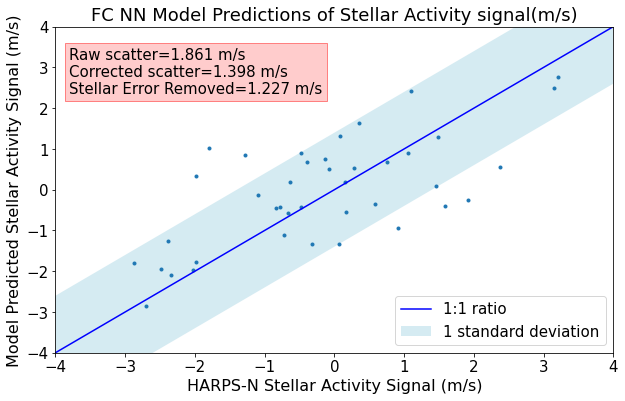

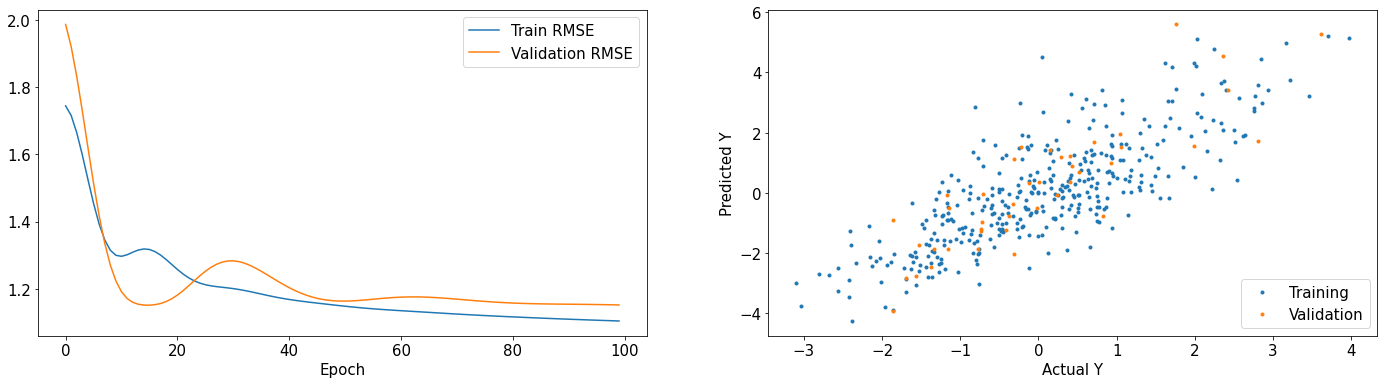

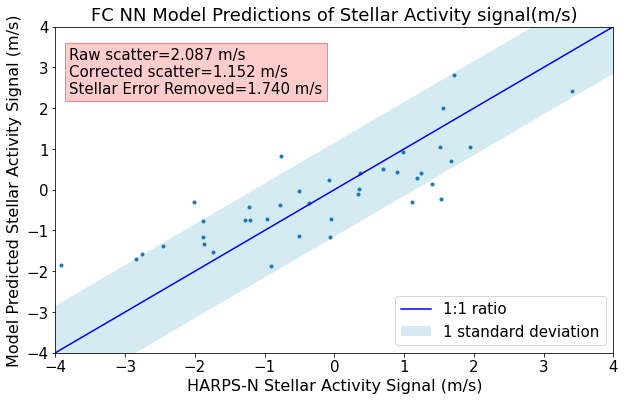

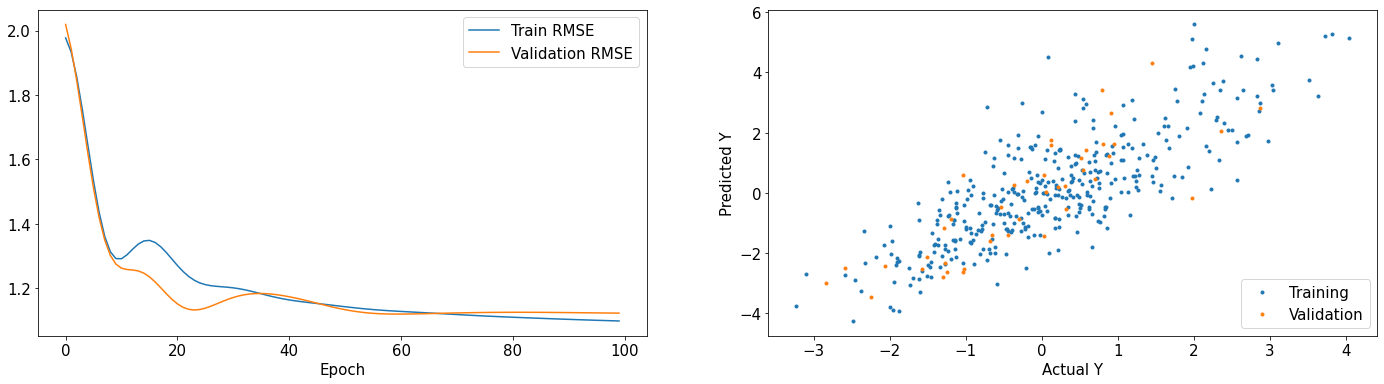

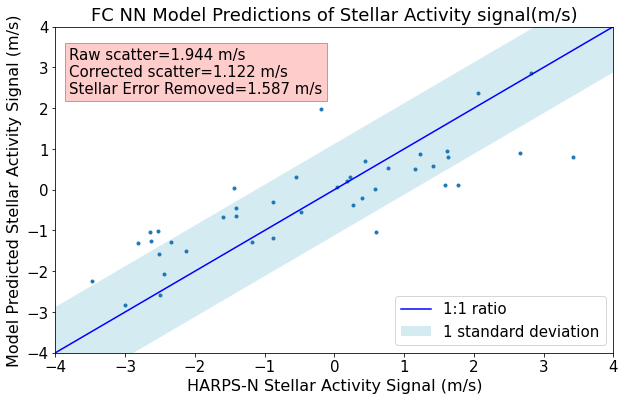

In [61]:
# series code

LOG_DIR_1 = "gdrive/Shareddrives/Exoplanet_RV/logs/" + time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(LOG_DIR_1)

# Log the hparam config. This is optional but makes tensorboard show the right ranges.
with tf.summary.create_file_writer(LOG_DIR_1).as_default():
  hp.hparams_config(
    hparams=[
             hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2)),
             hp.HParam('num_dense_units', hp.Discrete([100, 200, 500, 1000])),
             hp.HParam('num_dense_layers', hp.Discrete([4, 8, 12, 16])),
             hp.HParam('weight_decay', hp.RealInterval(5e-4,5e-2))],
    metrics=[hp.Metric("val_rmse", display_name='RMSE'),
             hp.Metric("original_rmse", display_name="OG RMSE"),
             hp.Metric("difference_rmse", display_name="diff RMSE")
             ],
  )

model_num = 1
RMSE_list = []
all_pred_bjd_val = []

rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []

for s in range(0, 1):#len(VAL_FILE_NAME_LIST)):
    ts = time.time()
    for i in range(0,1):#50):#30):
        hparams = configdict.ConfigDict(dict(
              num_features=46,
              learning_rate=np.random.choice(learning_rate_list),
              momentum=0.9,
              batch_size=1024,
              num_dense_units=int(np.random.choice(dense_units_list)),
              num_dense_layers=int(np.random.choice(num_dense_layers_list)),
              weight_decay=np.random.choice(weight_decay_list), #5e-4, #7e-2,
              gaussian_noise_scale=0,#1.5,
        ))
        epochs = np.random.choice(num_epochs_list)
        for index in range(0, len(VAL_FILE_NAME_LIST)):
            TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
            VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]

            bjd_run_val = []
            pred_run_val = []
            labels_run_val = []
            k=0
            #for k in range(0,1):
            print("Model {}. Learning_rate: {:.5f}. Dense units: {}. Dense layers {}. Weight decay: {:.5f}".format(
                  model_num, hparams.learning_rate, hparams.num_dense_units, hparams.num_dense_layers, hparams.weight_decay))
            print("Cross-val number: "+str(index+1)+", Model archictect. num: "+str(i+1)+", Run number: "+str(k+1))
            model = FCModel(hparams)
            run_dir = LOG_DIR_1 + "/{}/".format(model_num)
            with tf.summary.create_file_writer(run_dir).as_default():
                hp.hparams(hparams)  # record the values used in this trial
                metric_values = train(model, hparams, plots="ON", model_name = "FC NN",num_epochs=epochs)
                final_metrics = metric_values[-1]

            print("________________________")
            print()
            mean_val_preds = np.mean(pred_run_val, axis=0)
            mean_val_labels = np.mean(labels_run_val, axis=0)
            mean_val_bjds = np.mean(bjd_run_val, axis=0)

            all_mean_val_preds.append(mean_val_preds)
            all_mean_val_labels.append(mean_val_labels)
            all_mean_val_bjds.append(mean_val_bjds)

            all_pred_val.append(pred_run_val)
            all_labels_val.append(labels_run_val)
            all_bjds_val.append(bjd_run_val)
        model_num += 1

print('Time in series:', time.time() - ts)


In [40]:
LOG_DIR_1

'gdrive/Shareddrives/Exoplanet_RV/logs/20211208-133241'

In [37]:
!ls $LOG_DIR_1

1
events.out.tfevents.1638988361.dhcp-10-29-48-180.dyn.mit.edu.862.630844.v2


In [38]:
%tensorboard --logdir $LOG_DIR_1

In [8]:
# 50 runs
%tensorboard --logdir 'gdrive/Shareddrives/Exoplanet_RV/logs/20211207-095830'#$LOG_DIR_1

Reusing TensorBoard on port 6008 (pid 91166), started 1:33:26 ago. (Use '!kill 91166' to kill it.)

In [9]:
# 115 runs

%tensorboard --logdir 'gdrive/Shareddrives/Exoplanet_RV/logs/20211206-233716'

Reusing TensorBoard on port 6007 (pid 89673), started 3:30:06 ago. (Use '!kill 89673' to kill it.)

In [176]:
# parallelize code

import multiprocess as mp
import time

# Define a function that compiles the global results
def get_result(result):
    global results
    results.append(result)

def my_fc_nn_optimizer(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, model_num):
    #model_num = 1
    result = []
    val_rmse_list = []
    
    rms_avg_list = []
    weight_decay_list_t = []
    gaussian_noise_list_t = []
    rms_x_list = []

    all_bjds_val = []
    all_pred_val = []
    all_labels_val = []
    all_mean_val_preds = []
    all_mean_val_bjds = []
    all_mean_val_labels = []
    all_mean_val_bjds = []
    
    
    hparams = configdict.ConfigDict(dict(
          num_features=46,
          learning_rate=np.random.choice(learning_rate_list),
          momentum=0.9,
          batch_size=1024,
          num_dense_units=int(np.random.choice(dense_units_list)),
          num_dense_layers=int(np.random.choice(num_dense_layers_list)),
          weight_decay=np.random.choice(weight_decay_list), #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5,
      ))
    epochs = np.random.choice(num_epochs_list)
    for index in range(0, len(VAL_FILE_NAME_LIST)):
        TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
        VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]

        bjd_run_val = []
        pred_run_val = []
        labels_run_val = []
        k=0
        #for k in range(0,1):
        print("Model {}. Learning_rate: {:.5f}. Dense units: {}. Dense layers {}. Weight decay: {:.5f}".format(
              model_num, hparams.learning_rate, hparams.num_dense_units, hparams.num_dense_layers, hparams.weight_decay))
        print("Cross-val number: "+str(index+1)+", Model archictect. num: "+str(i+1)+", Run number: "+str(k+1))
        model = FCModel(hparams)
        run_dir = LOG_DIR_1 + "/{}/".format(model_num)
        with tf.summary.create_file_writer(run_dir).as_default():
            hp.hparams(hparams)  # record the values used in this trial
            metric_values = train(model, hparams, plots="OFF", model_name = "FC NN",num_epochs=epochs)
            final_metrics = metric_values[-1]
            print("val_rmse: "+str(final_metrics['val_rmse']))

        print("________________________")
        print()
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)

        all_mean_val_preds.append(mean_val_preds)
        all_mean_val_labels.append(mean_val_labels)
        all_mean_val_bjds.append(mean_val_bjds)

        all_pred_val.append(pred_run_val)
        all_labels_val.append(labels_run_val)
        all_bjds_val.append(bjd_run_val)
        val_rmse_list.append(final_metrics['val_rmse'])
  
    result1 = np.mean(val_rmse_list)
    #result.append([1])
    model_num += 1

    return result

In [112]:
# Define a function that compiles the global results
def get_result(result):
    global results
    results.append(result)

# temp simple function
def temp_my_fc_nn_optimizer(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, model_num):
    result = []
    result.append([1])
    return result

In [152]:
from multiprocess import get_context
sys.modules['__main__'].__file__ = 'ipython'

In [175]:
if __name__ == '__main__':
    folder = 'logs/'
    if not os.path.isdir(folder):
            os.mkdir(folder)

    LOG_DIR_1 = folder + time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(LOG_DIR_1)

    # Log the hparam config. This is optional but makes tensorboard show the right ranges.
    with tf.summary.create_file_writer(LOG_DIR_1).as_default():
      hp.hparams_config(
        hparams=[
                 hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2)),
                 hp.HParam('num_dense_units', hp.Discrete([100, 200, 500, 1000])),
                 hp.HParam('num_dense_layers', hp.Discrete([4, 8, 12, 16])),
                 hp.HParam('weight_decay', hp.RealInterval(5e-4,5e-2))],
        metrics=[hp.Metric("val_rmse", display_name='RMSE'),
                 hp.Metric("original_rmse", display_name="OG RMSE"),
                 hp.Metric("difference_rmse", display_name="diff RMSE"),
                ],
      )

    results = []


    ts = time.time()
    # count the number of cpus present on your machine
    num_cpus = 2#mp.cpu_count()
    print("Number of CPUs used: "+str(num_cpus))

    # Pool class represents a pool of worker processes
    pool = mp.Pool(num_cpus)
    #pool = get_context("spawn").Pool(num_cpus)
    for model_num in range(1):
        # apply_async is applying the process asynchronously - meaning that it will start as soon as computing resources become available.
        # it will not wait for a task to finish to start a new one
        pool.apply_async(my_fc_nn_optimizer, args=(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, model_num), callback=get_result)
    pool.close()

    pool.join()

    print('Time in parallel:', time.time() - ts)

logs/20211206-231820
Number of CPUs used: 2
Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 2, Run number: 1


Process ForkPoolWorker-106:
Traceback (most recent call last):
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/connection.py", line 382, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/connection.py", line 410, in _recv_bytes
    buf = self._recv(4)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/queues.py

KeyboardInterrupt: 

Process ForkPoolWorker-110:
Process ForkPoolWorker-109:
Traceback (most recent call last):
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/

In [147]:
results

[]

In [149]:
LOG_DIR_1

'logs/20211206-173838'

In [164]:
!ls $LOG_DIR_1

0
events.out.tfevents.1638830466.dhcp-10-29-86-57.dyn.mit.edu.79853.1646176.v2


In [165]:
%tensorboard --logdir $LOG_DIR_1

In [177]:
# Record time before running the code in series

folder = 'logs/'
if not os.path.isdir(folder):
        os.mkdir(folder)

LOG_DIR_1 = folder + time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(LOG_DIR_1)

# Log the hparam config. This is optional but makes tensorboard show the right ranges.
with tf.summary.create_file_writer(LOG_DIR_1).as_default():
  hp.hparams_config(
    hparams=[
             hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2)),
             hp.HParam('num_dense_units', hp.Discrete([100, 200, 500, 1000])),
             hp.HParam('num_dense_layers', hp.Discrete([4, 8, 12, 16])),
             hp.HParam('weight_decay', hp.RealInterval(5e-4,5e-2))],
    metrics=[hp.Metric("val_rmse", display_name='RMSE'),
             hp.Metric("original_rmse", display_name="OG RMSE"),
             hp.Metric("difference_rmse", display_name="diff RMSE"),
            ],
  )


RMSE_list = []
all_pred_bjd_val = []

rms_avg_list = []
weight_decay_list_t = []
gaussian_noise_list_t = []
rms_x_list = []

all_bjds_val = []
all_pred_val = []
all_labels_val = []
all_mean_val_preds = []
all_mean_val_bjds = []
all_mean_val_labels = []


ts = time.time()

for i in range(1):
      my_fc_nn_optimizer(learning_rate_list, dense_units_list, num_dense_layers_list, weight_decay_list, LOG_DIR_1, i)
        
print('Time in serial:', time.time() - ts)

logs/20211206-231840
Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 1, Model archictect. num: 1, Run number: 1
1: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.937
10: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.937
20: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.937
30: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.937
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.937
Raw scatter=1.944 m/s
Corrected scatter=1.937 m/s
Stellar Error Removed=0.167 m/s
val_rmse: 1.9367962
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 2, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.936
10: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.936
20: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.936
30: Train loss: 3.289, Train RMSE: 1.814, Val RMSE: 1.936
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.175 m/s
val_rmse: 1.9361453
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 3, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.933
10: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.933
20: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.933
30: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.934
40: Train loss: 3.285, Train RMSE: 1.812, Val RMSE: 1.934
Raw scatter=1.944 m/s
Corrected scatter=1.934 m/s
Stellar Error Removed=0.199 m/s
val_rmse: 1.933838
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 4, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.934
10: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.935
20: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.935
30: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.935
40: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.178 m/s
val_rmse: 1.9358609
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 5, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.933
10: Train loss: 3.299, Train RMSE: 1.816, Val RMSE: 1.934
20: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 1.934
30: Train loss: 3.292, Train RMSE: 1.815, Val RMSE: 1.934
40: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.935
Raw scatter=1.944 m/s
Corrected scatter=1.935 m/s
Stellar Error Removed=0.189 m/s
val_rmse: 1.9347628
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 6, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.935
10: Train loss: 3.3, Train RMSE: 1.816, Val RMSE: 1.935
20: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.935
30: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.935
40: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.179 m/s
val_rmse: 1.9357165
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 7, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.936
10: Train loss: 3.292, Train RMSE: 1.814, Val RMSE: 1.935
20: Train loss: 3.289, Train RMSE: 1.814, Val RMSE: 1.935
30: Train loss: 3.286, Train RMSE: 1.813, Val RMSE: 1.935
40: Train loss: 3.284, Train RMSE: 1.812, Val RMSE: 1.935
Raw scatter=1.944 m/s
Corrected scatter=1.935 m/s
Stellar Error Removed=0.184 m/s
val_rmse: 1.9352895
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 8, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.936
10: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 1.936
20: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.936
30: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.936
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.180 m/s
val_rmse: 1.9356406
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 9, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.934
10: Train loss: 3.296, Train RMSE: 1.815, Val RMSE: 1.934
20: Train loss: 3.293, Train RMSE: 1.815, Val RMSE: 1.934
30: Train loss: 3.29, Train RMSE: 1.814, Val RMSE: 1.934
40: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.935
Raw scatter=1.944 m/s
Corrected scatter=1.935 m/s
Stellar Error Removed=0.189 m/s
val_rmse: 1.9347588
________________________

Model 0. Learning_rate: 0.00010. Dense units: 1000. Dense layers 12. Weight decay: 0.00139
Cross-val number: 10, Model archictect. num: 1, Run number: 1


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1: Train loss: 3.295, Train RMSE: 1.815, Val RMSE: 1.937
10: Train loss: 3.294, Train RMSE: 1.815, Val RMSE: 1.936
20: Train loss: 3.291, Train RMSE: 1.814, Val RMSE: 1.936
30: Train loss: 3.288, Train RMSE: 1.813, Val RMSE: 1.936
40: Train loss: 3.287, Train RMSE: 1.813, Val RMSE: 1.936
Raw scatter=1.944 m/s
Corrected scatter=1.936 m/s
Stellar Error Removed=0.176 m/s
val_rmse: 1.9360467
________________________

Time in serial: 232.7624146938324


/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zdebeurs/opt/anaconda3/envs/tensorflow_env2/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [171]:
LOG_DIR_1

'logs/20211206-225742'

In [178]:
!ls $LOG_DIR_1

0
events.out.tfevents.1638850720.dhcp-10-29-86-57.dyn.mit.edu.79853.2415682.v2


In [179]:
%tensorboard --logdir $LOG_DIR_1

# CNN Optimize Hyperparameters (08.31.21)

In [55]:
from tensorboard.plugins.hparams import api as hp
import shutil
import time

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [56]:
# Define the ranges of values that each hyperparameter can take

exp_list = np.random.uniform(2,4, 1000)
learning_rate_list = [10**-exp_list[0], 10**-exp_list[1], 10**-exp_list[2]]

conv_kernel_size_list = [3,5,7]
num_conv_filters_list = [8, 16, 32]
num_conv_layers_list = [2, 4, 6]
dense_units_list = [100, 200, 500, 1000]
num_dense_layers_list = [1, 2, 4, 6, 8]
weight_decay_list = np.geomspace(0.0005, 0.05, 1000)
num_epochs_list = [50, 55, 65, 70, 80, 90, 100]

In [62]:
LOG_DIR_4 = "logs/" + time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(LOG_DIR_4)

# Log the hparam config. This is optional but makes tensorboard show the right ranges.
with tf.summary.create_file_writer(LOG_DIR_4).as_default():
  hp.hparams_config(
    hparams=[
             hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2)),
             hp.HParam('conv_kernel_size', hp.Discrete([3, 5, 7])),
             hp.HParam('num_conv_filters', hp.Discrete([8, 16, 32])),
             hp.HParam('num_conv_layers', hp.Discrete([2, 4, 6])),
             hp.HParam('num_dense_units', hp.Discrete([100, 200, 500, 1000])),
             hp.HParam('num_dense_layers', hp.Discrete([1, 2, 4, 6, 8])),
             hp.HParam('weight_decay', hp.RealInterval(5e-4,5e-2)),
             hp.HParam('epochs', hp.Discrete([50, 55, 65, 70, 80, 90, 100]))],
    metrics=[hp.Metric("val_rmse", display_name='RMSE'),
             hp.Metric("original_rmse", display_name="OG RMSE"),
             hp.Metric("difference_rmse", display_name="diff RMSE")
            ],
  )

model_num = 1
RMSE_list = []
all_pred_bjd_val = []

for i in trange(0,2):#30):
      rms_avg_list = []
      weight_decay_list_t = []
      gaussian_noise_list_t = []
      rms_x_list = []
      all_bjds_val = []
      all_pred_val = []
      all_labels_val = []
      all_mean_val_preds = []
      all_mean_val_bjds = []
      all_mean_val_labels = []

      hparams = configdict.ConfigDict(dict(
          num_features=46,
          learning_rate=np.random.choice(learning_rate_list),
          momentum=0.9,
          batch_size=1024,
          conv_kernel_size=int(np.random.choice(conv_kernel_size_list)),
          num_conv_filters=int(np.random.choice(num_conv_filters_list)),
          num_conv_layers=int(np.random.choice(num_conv_layers_list)),
          num_dense_units=int(np.random.choice(dense_units_list)),
          num_dense_layers=int(np.random.choice(num_dense_layers_list)),
          weight_decay=np.random.choice(weight_decay_list), #5e-4, #7e-2,
          gaussian_noise_scale=0,#1.5,
          epochs = int(np.random.choice(num_epochs_list))
      ))
      epochs =  hparams.epochs
      for index in range(0, len(VAL_FILE_NAME_LIST)):
        TRAIN_FILE_NAME = TRAIN_FILE_NAME_LIST[index]
        VAL_FILE_NAME = VAL_FILE_NAME_LIST[index]

        bjd_run_val = []
        pred_run_val = []
        labels_run_val = []
        print("Model {}. Learning_rate: {:.5f}. Num conv filters: {}. Num conv layers: {}. Dense units: {}. Dense layers {}. Weight decay: {:.5f}".format(
            model_num, hparams.learning_rate, hparams.num_conv_filters, hparams.num_conv_layers, hparams.num_dense_units, hparams.num_dense_layers, hparams.weight_decay))
        print("Cross-val number: "+str(index+1)+", Model archictect. num: "+str(i+1)+", Run number: "+str(k+1))
        model = CNNModel(hparams)
        run_dir = LOG_DIR_4 + "/{}/".format(model_num)
        with tf.summary.create_file_writer(run_dir).as_default():
          hp.hparams(hparams)  # record the values used in this trial
          metric_values = train(model, hparams, plots="OFF", model_name = "CNN",num_epochs=epochs)#np.random.choice(num_epochs_list))
          final_metrics = metric_values[-1]

        print("________________________")
        print()
        mean_val_preds = np.mean(pred_run_val, axis=0)
        mean_val_labels = np.mean(labels_run_val, axis=0)
        mean_val_bjds = np.mean(bjd_run_val, axis=0)

        all_mean_val_preds.append(mean_val_preds)
        all_mean_val_labels.append(mean_val_labels)
        all_mean_val_bjds.append(mean_val_bjds)

        all_pred_val.append(pred_run_val)
        all_labels_val.append(labels_run_val)
        all_bjds_val.append(bjd_run_val)
      model_num += 1

logs/20211208-152841


  0%|          | 0/2 [00:00<?, ?it/s]

Model 1. Learning_rate: 0.00214. Num conv filters: 32. Num conv layers: 4. Dense units: 500. Dense layers 8. Weight decay: 0.03757
Cross-val number: 1, Model archictect. num: 1, Run number: 1
1: Train loss: 3.43, Train RMSE: 1.852, Val RMSE: 1.584
10: Train loss: 3.43, Train RMSE: 1.852, Val RMSE: 1.587
20: Train loss: 3.426, Train RMSE: 1.851, Val RMSE: 1.59
30: Train loss: 3.425, Train RMSE: 1.851, Val RMSE: 1.592
40: Train loss: 3.424, Train RMSE: 1.851, Val RMSE: 1.592
50: Train loss: 3.424, Train RMSE: 1.851, Val RMSE: 1.592
60: Train loss: 3.424, Train RMSE: 1.851, Val RMSE: 1.592
70: Train loss: 3.424, Train RMSE: 1.851, Val RMSE: 1.592
80: Train loss: 3.424, Train RMSE: 1.851, Val RMSE: 1.592
90: Train loss: 3.424, Train RMSE: 1.851, Val RMSE: 1.592
100: Train loss: 3.424, Train RMSE: 1.851, Val RMSE: 1.592
Raw scatter=1.590 m/s
Corrected scatter=1.592 m/s
Stellar Error Removed=0.076 m/s
________________________

Model 1. Learning_rate: 0.00214. Num conv filters: 32. Num conv l

90: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.918
100: Train loss: 3.302, Train RMSE: 1.817, Val RMSE: 1.918
Raw scatter=1.846 m/s
Corrected scatter=1.918 m/s
Stellar Error Removed=0.518 m/s
________________________

Model 1. Learning_rate: 0.00214. Num conv filters: 32. Num conv layers: 4. Dense units: 500. Dense layers 8. Weight decay: 0.03757
Cross-val number: 10, Model archictect. num: 1, Run number: 1
1: Train loss: 3.299, Train RMSE: 1.816, Val RMSE: 1.928
10: Train loss: 3.298, Train RMSE: 1.816, Val RMSE: 1.927
20: Train loss: 3.297, Train RMSE: 1.816, Val RMSE: 1.926
30: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.926
40: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.926
50: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.926
60: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.926
70: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.926
80: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.926
90: Train loss: 3.296, Train RMSE: 1.816, Val RMSE: 1.926
100

1: Train loss: 3.299, Train RMSE: 1.816, Val RMSE: 1.928
10: Train loss: 3.283, Train RMSE: 1.812, Val RMSE: 1.923
20: Train loss: 3.263, Train RMSE: 1.806, Val RMSE: 1.917
30: Train loss: 3.251, Train RMSE: 1.803, Val RMSE: 1.914
40: Train loss: 3.242, Train RMSE: 1.801, Val RMSE: 1.911
50: Train loss: 3.235, Train RMSE: 1.799, Val RMSE: 1.909
60: Train loss: 3.23, Train RMSE: 1.797, Val RMSE: 1.907
70: Train loss: 3.228, Train RMSE: 1.797, Val RMSE: 1.907
Raw scatter=1.947 m/s
Corrected scatter=1.907 m/s
Stellar Error Removed=0.394 m/s
________________________



In [59]:
%tensorboard --logdir $LOG_DIR_4

In [60]:
LOG_DIR_4

'logs/20211208-151102'